# Visualisierung der Features

In [1]:
EXAMPLE_NAME = 'CometInterceptor_1,4_1'

SAMPLE_RATE = 22_050

LABEL_WHISTLE = 1
LABEL_NO_WHISTLE = -1

## Beispiel einlesen

In [2]:
import numpy as np
import os

# determine path to `src/research/fft`
cwd = os.getcwd()
src_dir = os.path.join(cwd, os.path.join(os.pardir, os.pardir))
data_dir = os.path.join(src_dir, 'data')

csv_path = os.path.join(data_dir, EXAMPLE_NAME + '.csv')
audio_path = os.path.join(data_dir, EXAMPLE_NAME + '.flac')

assert(os.path.isfile(csv_path))
assert(os.path.isfile(audio_path))

In [3]:
import librosa
import pandas as pd

waveforms = []
labels = []

label_df = pd.read_csv(csv_path)
for index, row in label_df.iterrows():
    start = max(0, row['start'])
    end = row['end']
    duration = end - start
    
    if duration <= 0:
        continue
    
    y, sr = librosa.load(audio_path,
                         sr=SAMPLE_RATE, mono=True,
                         offset=start, duration=duration)
    
    waveforms.append(y)
    label = LABEL_NO_WHISTLE if row['label'] == 'No_Whistle' else LABEL_WHISTLE
    labels.append(label)

labels = np.array(labels)

## Auswahl eines Datums

In [4]:
whistle_idx = np.where(labels == LABEL_WHISTLE)[0]
no_whistle_idx = np.where(labels == LABEL_NO_WHISTLE)[0]

whistle_waveform = waveforms[whistle_idx[0]]
no_whistle_waveform = waveforms[no_whistle_idx[2]]

## FFT Plot

In [5]:
whistle_fft = np.fft.fft(whistle_waveform)
whistle_fft_freq = np.fft.fftfreq(whistle_fft.size, d=1/SAMPLE_RATE)

no_whistle_fft = np.fft.fft(no_whistle_waveform,)
no_whistle_fft_freq = np.fft.fftfreq(no_whistle_fft.size, d=1/SAMPLE_RATE)

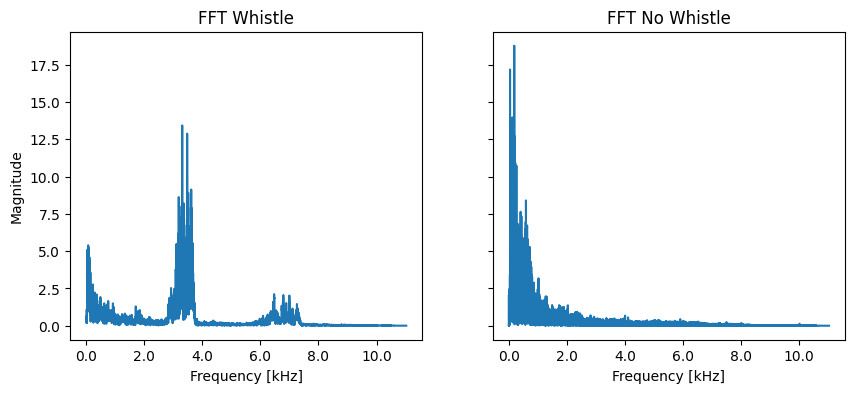

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['savefig.bbox'] = 'tight'
from  matplotlib.ticker import FuncFormatter

# format x label in kHz instead of Hz
formatter = FuncFormatter(lambda x, pos: '{:.1f}'.format(x / 1000))

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

# fft whistle plot
axs[0].plot(whistle_fft_freq[:whistle_fft_freq.size // 2],
            np.abs(whistle_fft[:whistle_fft.size // 2]))
axs[0].set_title('FFT Whistle')
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_xlabel('Frequency [kHz]')
axs[0].set_ylabel('Magnitude')

# fft no whistle plot
axs[1].plot(no_whistle_fft_freq[:no_whistle_fft_freq.size // 2],
            np.abs(no_whistle_fft[:no_whistle_fft.size // 2]))
axs[1].set_title('FFT No Whistle')
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel('Frequency [kHz]')

plt.savefig('fft_feature_plot.png')
plt.show()

## MFCC Plot

In [8]:
mfcc_whistle = librosa.feature.mfcc(y=whistle_waveform, sr=SAMPLE_RATE)
mfcc_no_whistle = librosa.feature.mfcc(y=no_whistle_waveform, sr=SAMPLE_RATE)

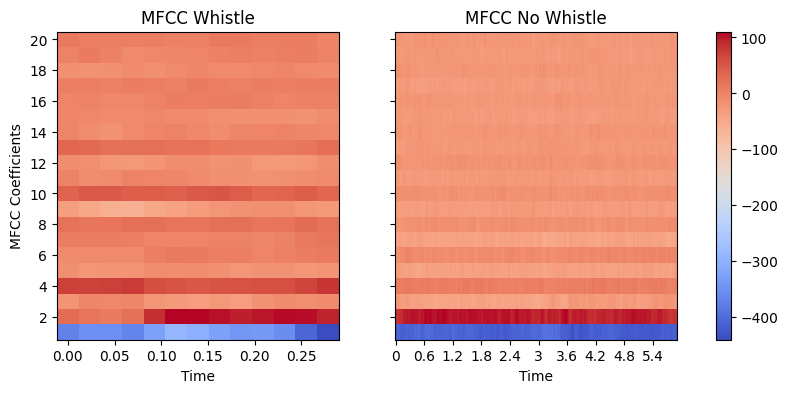

In [48]:
formatter = FuncFormatter(lambda x, pos: '{:.2f}'.format(x))

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10,4))

img_no_w = librosa.display.specshow(mfcc_whistle, x_axis='time', ax=axs[0])
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_title('MFCC Whistle')

img_w = librosa.display.specshow(mfcc_no_whistle, x_axis='time', ax=axs[1])
axs[1].set_title('MFCC No Whistle')

# share colour bar
fig.colorbar(img_no_w, ax=[axs[0], axs[1]])

axs[0].set_ylabel('MFCC Coefficients')
axs[0].set_yticks(ticks=[i for i in range(1, mfcc_whistle.shape[0], 2)],
                  labels=[(i + 1) for i in range(1, mfcc_whistle.shape[0], 2)])

plt.savefig('mfcc_feature_plot.png')
plt.show()